# Flu Time Series Forecast - LSTM model
_Cong Tung Nguyen (June 2021)_ 
<br>
----

In this notebook I will apply on of the mostly used deep learning model for time series analysis, which is the LSTM model. I will use the data which was prepared in the R file.

### LSTM intuition:

Traditional neural networks do not have the ability, to use the information in the past, or we can also say that they do not have a memory cell, which helps the model to decide what is going to happen in the future.

The solution for this issue is the RNN (Recurrent Neural Network). They are networks with loops in them, allowing information to persist. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor.

**Vanishing Gradient Problem:** 

In ANN the Gradient Descent algorithm finds the global minimum of the cost function for the network setup. Basically, the information travels through the neural network from input neurons to the output neurons, while the error is calculated and propagated back through the network to update the weights.

In RNN all the neurons far back in time contributed in calculating the output. So in the backpropagation process, we have to go all the way back in time into these neurons. During the backprop, we need to pass the derivative from back to front, which involves multiplying a number less than 1 for many times. In RNN the network can be really deep, because we have to go all the way back in each time, therefore at some point the gradient will become extremely small  (almost zero), and eventually the neurons will stop learning. 

The RNN unfortunately is not capable of learning long term dependencies in practice. The LSTM networks are the solution for this issue.

**Long Short Term Memory (LSTM):**

The LSTM is a special kind of RNN, which is capable of handling long term dependencies. The standtard RNN has a very simple structure, for instance a single tanh layer. LSTM also a chain like structure like RNN, but it has 4 layers instead of one single layer. There are 4 parts of the LSTM network. 

It has a **memory cell**, which runs straight down the entire chain, with only some minor linear interactions. The **forget gate layer's** task is to decide what information we are going to throw away from the memory cell. The **input gate layer** decides what new information we are going to store in the memory cell. The last part is the **output gate layer**, which generates the output. This output will be based on our memory cell's state, but will be a filtered version.

So the most important thing is that the LSTM does have the ability to remove or add information into the memory cell, carefully regulated by structures called gates. 

**LSTM network:**

<img src="plot/LSTM2.png" style="width: 50em;">

### 1. Importing the libraries:

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import dataframe_image as dfi
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

### 2. Importing the dataset:

In [2]:
fludat_pivot = pd.read_csv('./dataset/Flu_pivot.csv')

In [3]:
fludat_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sdate      546 non-null    object
 1   Processed  546 non-null    int64 
 2   A_total    546 non-null    int64 
 3   B_total    546 non-null    int64 
 4   All_total  546 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 21.5+ KB


In [4]:
# Parsing to datetime
fludat_pivot['sdate'] = pd.to_datetime(fludat_pivot['sdate'])

### 3. Data understanding:

In [5]:
fludat_pivot.head()

,sdate,Processed,A_total,B_total,All_total
0,2010-01-04,9312,1999,1,2000
1,2010-01-11,10728,1404,15,1419
2,2010-01-18,9027,1135,49,1184
3,2010-01-25,8030,515,18,533
4,2010-02-01,7788,502,14,516


In [6]:
# Extract year,month,day from date
fludat_pivot['year'] = fludat_pivot['sdate'].dt.year
fludat_pivot['month'] = fludat_pivot['sdate'].dt.month
fludat_pivot['day'] = fludat_pivot['sdate'].dt.day

In [7]:
fludat_pivot.head()

,sdate,Processed,A_total,B_total,All_total,year,month,day
0,2010-01-04,9312,1999,1,2000,2010,1,4
1,2010-01-11,10728,1404,15,1419,2010,1,11
2,2010-01-18,9027,1135,49,1184,2010,1,18
3,2010-01-25,8030,515,18,533,2010,1,25
4,2010-02-01,7788,502,14,516,2010,2,1


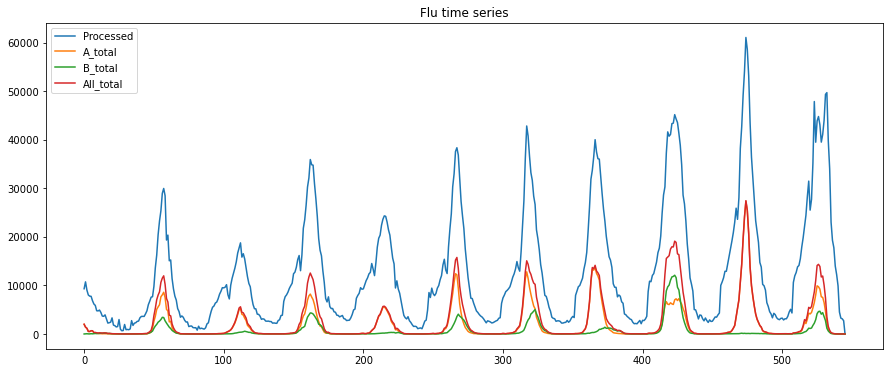

In [8]:
# Check the data through line plot
plt.figure(figsize=(15,6))
plt.plot(fludat_pivot[['Processed','A_total','B_total','All_total']])
plt.legend(['Processed','A_total','B_total','All_total'])
plt.title('Flu time series')
plt.show()

In [9]:
# Pivot table to check the average of each month (Positive cases)
fludat_pivot.groupby(['month'], as_index=False)['All_total'].mean()

,month,All_total
0,1,8640.625000
1,2,10849.133333
2,3,5264.041667
3,4,1551.791667
4,5,283.916667
5,6,50.911111
6,7,22.044444
7,8,18.250000
8,9,29.279070
9,10,112.044444


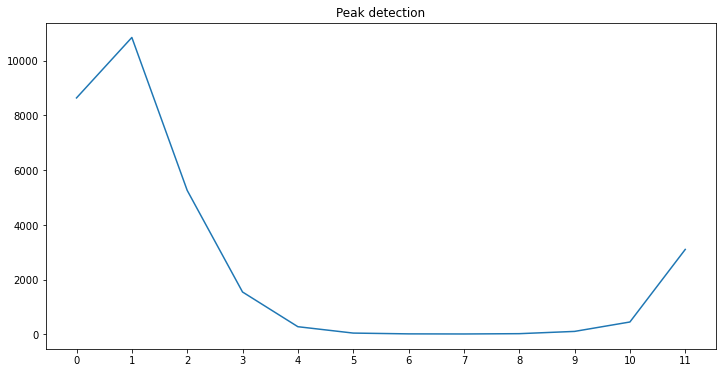

In [10]:
# Which month is the peak in average
plt.figure(figsize=(12,6))
plt.plot(fludat_pivot.groupby(['month'], as_index=False)['All_total'].mean()['All_total'])
plt.xticks(fludat_pivot.groupby(['month'], as_index=False)['All_total'].mean().index)
plt.title('Peak detection')
plt.show()

The peak is around december, january, february as we can see it from the graph.

#### Anomaly detection

In [17]:
# Anomaly detection Seasonal method
months_deviation = fludat_pivot.groupby(['month'])['All_total'].std()

Text(0, 0.5, 'Total Positive Cases')

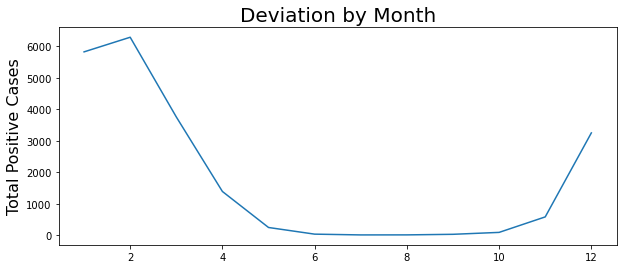

In [19]:
plt.figure(figsize=(10,4))
plt.plot(months_deviation)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Total Positive Cases', fontsize=16)

In january and february the deviations are much bigger, that indicates that there could be an anomaly existing.

**January:**

In [34]:
# January data
anomaly_temp_df = fludat_pivot[fludat_pivot['sdate'].dt.month == 1]

In [48]:
# Check for minimum dev
min_dev = 9999999
curr_anomaly = None
for date in anomaly_temp_df.index:
    other_data = anomaly_temp_df[anomaly_temp_df.index != date]
    curr_dev = other_data['All_total'].std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

anomaly_temp_df[anomaly_temp_df.index == curr_anomaly]

,sdate,Processed,A_total,B_total,All_total,year,month,day
473,2019-01-28,54128,24017,136,24153,2019,1,28


**February:**

In [49]:
# February data
anomaly_temp_df = fludat_pivot[fludat_pivot['sdate'].dt.month == 2]

In [50]:
# Check for minimum dev
min_dev = 9999999
curr_anomaly = None
for date in anomaly_temp_df.index:
    other_data = anomaly_temp_df[anomaly_temp_df.index != date]
    curr_dev = other_data['All_total'].std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

anomaly_temp_df[anomaly_temp_df.index == curr_anomaly]

,sdate,Processed,A_total,B_total,All_total,year,month,day
474,2019-02-04,61041,27344,97,27441,2019,2,4


In [12]:
# Series
forecast_data = fludat_pivot.set_index(fludat_pivot['sdate'])['All_total']
forecast_data.name = 'Positive_cases'
forecast_data

sdate
2010-01-04    2000
2010-01-11    1419
2010-01-18    1184
2010-01-25     533
2010-02-01     516
              ... 
2020-05-18       3
2020-05-25       3
2020-06-01       1
2020-06-08       4
2020-06-15       0
Name: Positive_cases, Length: 546, dtype: int64

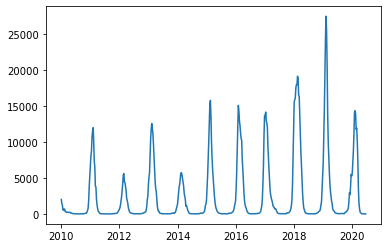

In [13]:
# Plot series
plt.plot(forecast_data)

### 4. Data preparation for modeling:

In [14]:
# Splitting the dataset into train and test 80% - 20%
train_size = int(len(forecast_data)*0.8)
test_size = len(forecast_data)-train_size

training_data = np.array(forecast_data[0:train_size])
test_data = np.array(forecast_data[train_size:len(forecast_data)])

In [15]:
 # LSTM are sensitive to the scale of the data, so we apply minmax scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scaled array
training_data_scaled = scaler.fit_transform(training_data.reshape(-1,1))
test_data_scaled = scaler.transform(test_data.reshape(-1,1))

In [16]:
training_data_scaled.shape

(436, 1)

In [17]:
test_data_scaled.shape

(110, 1)

In [18]:
# Within the 'training_data' and 'test_data', we create x_train,x_test, y_train, y_test
def create_data(dataset, time_step = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        data_X.append(a.tolist())
        data_Y.append(dataset[i + time_step, 0].tolist())
    return np.array(data_X), np.array(data_Y)

In [19]:
# Time_step hyperparameter tuning
time_step = 3

X_train, y_train = create_data(training_data_scaled, time_step)
X_test, y_test = create_data(test_data_scaled, time_step)

In [20]:
print('X_train shape: ',X_train.shape, ', y_train shape: ',y_train.shape)
print('------------------------')
print('X_test shape: ',X_test.shape, ', y_test shape: ',y_test.shape)

X_train shape:  (432, 3) , y_train shape:  (432,)
------------------------
X_test shape:  (106, 3) , y_test shape:  (106,)


### 5. Modeling:

We are going to try out different LSTM architectures.

In [21]:
# For LSTM we need to add an additional dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### a) Vanilla LSTM

In [22]:
# Create stack LSTM model
model = Sequential()
model.add(LSTM(50, input_shape = (3,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
# Training
EPOCHS = 50
H = model.fit(X_train,y_train, epochs = EPOCHS, batch_size = 3, validation_split=0.25, shuffle=False, verbose = 1)

Epoch 1/50
108/108 [==============================] - 3s 14ms/step - loss: 0.0155 - val_loss: 0.0253
Epoch 2/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0151
Epoch 3/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0144
Epoch 4/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0141
Epoch 5/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0133
Epoch 6/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0129
Epoch 7/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0123
Epoch 8/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0117
Epoch 9/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0109
Epoch 10/50
108/108 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.010

In [24]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


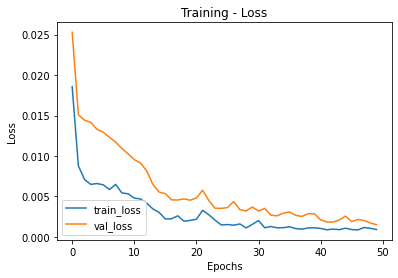

In [25]:
# Plot the training and validation loss
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model1_training_plot.png")

In [26]:
# Prediction and inverse scaling
y_pred = model.predict(X_test)
y_pred_realval = scaler.inverse_transform(y_pred)

In [27]:
# Accuracy
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
lstm_mae = mean_absolute_error(y_test,y_pred)
print('Scaled RMSE: ',lstm_rmse)
print('Inverse scaled RMSE: ', scaler.inverse_transform(np.array(lstm_rmse).reshape(1,-1))[0][0])
print('Scaled MAE: ',lstm_mae)
print('Inverse scaled MAE: ', scaler.inverse_transform(np.array(lstm_mae).reshape(1,-1))[0][0])

Scaled RMSE:  0.046728236485535195
Inverse scaled RMSE:  894.929871002092
Scaled MAE:  0.027243339258134394
Inverse scaled MAE:  522.5929698836901


In [28]:
print(y_pred_realval.shape)
print(np.array(forecast_data).reshape(len(forecast_data),1).shape)

(106, 1)
(546, 1)


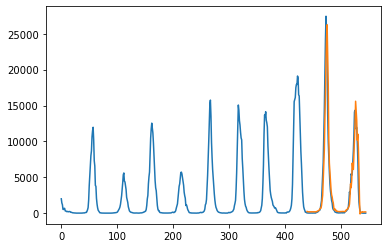

In [29]:
# Plotting the prediction and the actual value
test_predict = np.empty_like(np.array(forecast_data).reshape(len(forecast_data),1))
test_predict[:,:] = np.nan
test_predict = np.where(test_predict == -9223372036854775808, np.nan, test_predict)
test_predict[546-106:,:] = y_pred_realval
plt.plot(np.array(forecast_data).reshape(len(forecast_data),1))
plt.plot(test_predict)

#### b) Stacked LSTM

In [30]:
# Create stack LSTM model
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (3,1)))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
# Training
EPOCHS = 50
H = model.fit(X_train,y_train, epochs = EPOCHS, batch_size = 1, validation_split=0.25, shuffle=False, verbose = 1)

Epoch 1/50
324/324 [==============================] - 5s 5ms/step - loss: 0.0142 - val_loss: 0.0208
Epoch 2/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0219
Epoch 3/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0162
Epoch 4/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 5/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 6/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0081
Epoch 7/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 8/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 9/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 10/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0035

In [32]:
# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


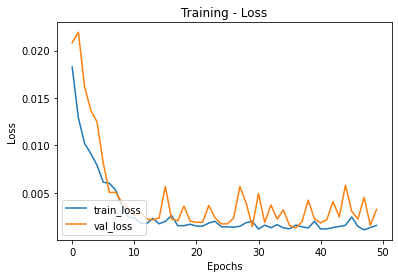

In [33]:
# Plot training and validation loss
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model2_training_plot.png")

In [34]:
# Prediction and inverse scale
y_pred = model.predict(X_test)
y_pred_realval = scaler.inverse_transform(y_pred)

In [35]:
# Accuracy
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
lstm_mae = mean_absolute_error(y_test,y_pred)
print('Scaled RMSE: ',lstm_rmse)
print('Inverse scaled RMSE: ', scaler.inverse_transform(np.array(lstm_rmse).reshape(1,-1))[0][0])
print('Scaled MAE: ',lstm_mae)
print('Inverse scaled MAE: ', scaler.inverse_transform(np.array(lstm_mae).reshape(1,-1))[0][0])

Scaled RMSE:  0.07533754680237224
Inverse scaled RMSE:  1441.6251818465314
Scaled MAE:  0.04558165812137425
Inverse scaled MAE:  873.0199050413405


In [36]:
print(y_pred_realval.shape)
print(np.array(forecast_data).reshape(len(forecast_data),1).shape)

(106, 1)
(546, 1)


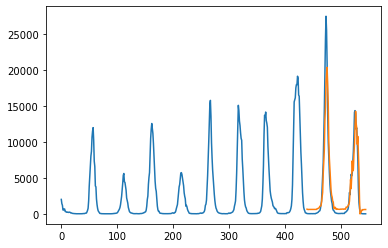

In [37]:
# Plotting the prediction and the actual values
test_predict = np.empty_like(np.array(forecast_data).reshape(len(forecast_data),1))
test_predict[:,:] = np.nan
test_predict = np.where(test_predict == -9223372036854775808, np.nan, test_predict)
test_predict[546-106:,:] = y_pred_realval
plt.plot(np.array(forecast_data).reshape(len(forecast_data),1))
plt.plot(test_predict)

#### c) Bidirectional LSTM

In [38]:
# Create model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, input_shape=(3,1))))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
# Training
EPOCHS = 50
H = model.fit(X_train,y_train, epochs = EPOCHS, batch_size = 1, validation_split=0.25, shuffle=False, verbose = 1)

Epoch 1/50
324/324 [==============================] - 5s 4ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 2/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0113
Epoch 3/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0090
Epoch 4/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0073
Epoch 5/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 6/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 7/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 8/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0107
Epoch 9/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 10/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0040

In [40]:
# Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (1, 100)                  20800     
_________________________________________________________________
dropout_3 (Dropout)          (1, 100)                  0         
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


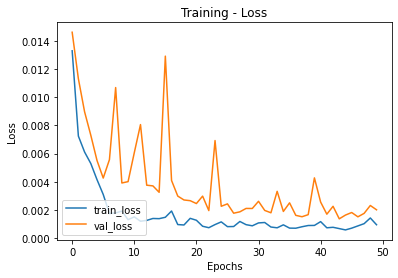

In [41]:
# Plot training and validation loss
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model3_training_plot.png")

In [42]:
# Prediction and inverse scale
y_pred = model.predict(X_test)
y_pred_realval = scaler.inverse_transform(y_pred)

In [43]:
# Accuracy
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
lstm_mae = mean_absolute_error(y_test,y_pred)
print('Scaled RMSE: ',lstm_rmse)
print('Inverse scaled RMSE: ', scaler.inverse_transform(np.array(lstm_rmse).reshape(1,-1))[0][0])
print('Scaled MAE: ',lstm_mae)
print('Inverse scaled MAE: ', scaler.inverse_transform(np.array(lstm_mae).reshape(1,-1))[0][0])

Scaled RMSE:  0.05363523545170041
Inverse scaled RMSE:  1026.915714246543
Scaled MAE:  0.04110357978995931
Inverse scaled MAE:  787.4483062063324


In [44]:
print(y_pred_realval.shape)
print(np.array(forecast_data).reshape(len(forecast_data),1).shape)

(106, 1)
(546, 1)


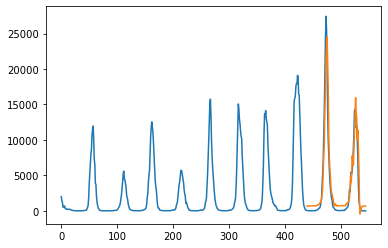

In [45]:
# Plotting the prediction and the actual values
test_predict = np.empty_like(np.array(forecast_data).reshape(len(forecast_data),1))
test_predict[:,:] = np.nan
test_predict = np.where(test_predict == -9223372036854775808, np.nan, test_predict)
test_predict[546-106:,:] = y_pred_realval
plt.plot(np.array(forecast_data).reshape(len(forecast_data),1))
plt.plot(test_predict)

#### d) Stacked LSTM with relu activation function

In [46]:
# Create model
model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences = True, input_shape=(3,1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [47]:
# Training
EPOCHS = 50
H = model.fit(X_train,y_train, epochs = EPOCHS, batch_size = 1, validation_split=0.25, shuffle=False, verbose = 1)

Epoch 1/50
324/324 [==============================] - 2s 3ms/step - loss: 0.0187 - val_loss: 0.0231
Epoch 2/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0199
Epoch 3/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0164
Epoch 4/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0142
Epoch 5/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 6/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 7/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 8/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 9/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 10/50
324/324 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0042

In [48]:
# Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


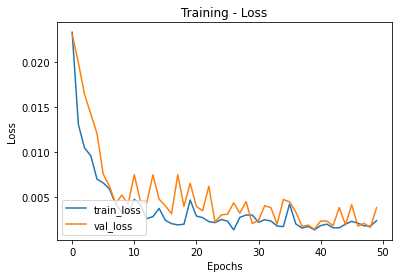

In [49]:
# Plot training and validation loss
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model4_training_plot.png")

In [50]:
# Prediction and inverse scale
y_pred = model.predict(X_test)
y_pred_realval = scaler.inverse_transform(y_pred)

In [51]:
# Accuracy
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
lstm_mae = mean_absolute_error(y_test,y_pred)
print('Scaled RMSE: ',lstm_rmse)
print('Inverse scaled RMSE: ', scaler.inverse_transform(np.array(lstm_rmse).reshape(1,-1))[0][0])
print('Scaled MAE: ',lstm_mae)
print('Inverse scaled MAE: ', scaler.inverse_transform(np.array(lstm_mae).reshape(1,-1))[0][0])

Scaled RMSE:  0.0689846494140442
Inverse scaled RMSE:  1320.2276656529707
Scaled MAE:  0.03821937450071901
Inverse scaled MAE:  732.3340273342395


In [52]:
print(y_pred_realval.shape)
print(np.array(forecast_data).reshape(len(forecast_data),1).shape)

(106, 1)
(546, 1)


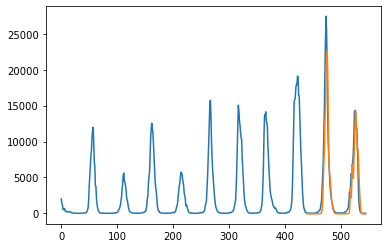

In [53]:
# Plotting the prediction and the actual values
test_predict = np.empty_like(np.array(forecast_data).reshape(len(forecast_data),1))
test_predict[:,:] = np.nan
test_predict = np.where(test_predict == -9223372036854775808, np.nan, test_predict)
test_predict[546-106:,:] = y_pred_realval
plt.plot(np.array(forecast_data).reshape(len(forecast_data),1))
plt.plot(test_predict)

### 6. Forecasting:

#### Predicting the next peak

In [155]:
# Last observation
forecast_data.tail(1).index[0]

Timestamp('2020-06-15 00:00:00')

Above we saw that the peak is around 12,01,02, so we are going to predict the next 8 months.

In [156]:
len(test_data)

110

In [157]:
# We need the last 3 value from the test data to start the prediction
x_input = test_data_scaled[len(test_data_scaled)-3:].reshape(1,-1)

# x_input to list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Prediction_array
prediction_arr = x_input.reshape(3,1)

# Find next 32 (8 months == 32 weeks) value
output = []
time_step = 3
i = 0

while(i<32):
    if(len(temp_input)>3):
        # Last 3 element after the first loop
        x_input = np.array(temp_input[1:])
        # Reshaping
        x_input = x_input.reshape(1, time_step, 1)
        # Predict
        y_hat = model.predict(x_input, verbose = 0)
        
        # Add to final pred arr
        temp_arr = np.vstack((x_input[:,1:].reshape(2,1),y_hat))
        prediction_arr = np.append(prediction_arr,temp_arr.reshape(1,3,1), axis=0)
        
        # Adding to the temp list
        temp_input.append(y_hat[0][0].tolist())
        # Change temp list to the last 3 value
        temp_input = temp_input[1:]
        # Add prediction to output
        output.append(y_hat[0][0].tolist())
        i = i+1
    
    else:
        # Last 3 value reshape and predict
        x_input = x_input.reshape(1, time_step, 1)
        y_hat = model.predict(x_input, verbose = 0)
        
        # Add to final prediction arr
        temp_arr = np.vstack((x_input[:,1:].reshape(2,1),y_hat))
        prediction_arr = np.stack((prediction_arr,temp_arr))
        
        # Adding the value to temp input list
        temp_input.append(y_hat[0][0].tolist())
        # Adding the value to output list
        output.append(y_hat[0][0].tolist())
        i = i+1

prediction_arr = prediction_arr.reshape(prediction_arr.shape[0],prediction_arr.shape[1],1)
print(output)
print('---------------------------------')
print(prediction_arr)

[0.009653192013502121, 0.022593602538108826, 0.04223279654979706, 0.06764882057905197, 0.10078657418489456, 0.1423988789319992, 0.1937461644411087, 0.2551858723163605, 0.3260883390903473, 0.4039219915866852, 0.48386266827583313, 0.55889892578125, 0.6211710572242737, 0.6643544435501099, 0.685956597328186, 0.687891960144043, 0.6749681234359741, 0.6526792645454407, 0.6257950663566589, 0.5979692339897156, 0.5718380808830261, 0.5492026209831238, 0.531173050403595, 0.5182770490646362, 0.5105537176132202, 0.5076433420181274, 0.508878231048584, 0.5133741497993469, 0.5201229453086853, 0.5280859470367432, 0.5362851619720459, 0.5438847541809082]
---------------------------------
[[[-5.23313622e-05]
  [ 1.04662724e-04]
  [-1.04662724e-04]]

 [[ 1.04662724e-04]
  [-1.04662724e-04]
  [ 9.65319201e-03]]

 [[-1.04662724e-04]
  [ 9.65319201e-03]
  [ 2.25936025e-02]]

 [[ 9.65319201e-03]
  [ 2.25936025e-02]
  [ 4.22327965e-02]]

 [[ 2.25936025e-02]
  [ 4.22327965e-02]
  [ 6.76488206e-02]]

 [[ 4.2232796

In [158]:
# Predict and inverse scale
y_pred_2yrs = model.predict(prediction_arr)
y_pred_2yrs = scaler.inverse_transform(y_pred_2yrs)

In [159]:
print(len(forecast_data))
print(len(y_pred_2yrs))

546
33


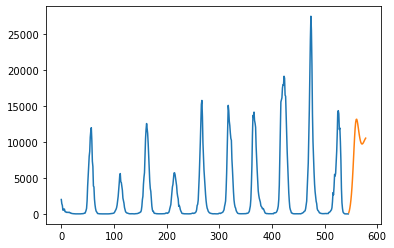

In [160]:
# Plot the prediction
plt.plot(np.arange(0,546),forecast_data)
plt.plot(np.arange(546,546+33),y_pred_2yrs)

In [161]:
# Get the dates for the predictions, and put it in a dataframe
last_date = fludat_pivot.tail(1)['sdate']
yhat_temp = y_pred_2yrs.reshape(len(y_pred_2yrs),)
dates = []

for i in range(len(yhat_temp)):
    last_date = last_date + datetime.timedelta(days=7)
    dates.append(last_date)

In [162]:
df_pred = pd.DataFrame({'Dates':dates,
                        'Predicted_value':yhat_temp})

In [163]:
df_pred.head()

,Dates,Predicted_value
0,"545 2020-06-22 Name: sdate, dtype: datetime6...",186.462845
1,"545 2020-06-29 Name: sdate, dtype: datetime6...",433.741058
2,"545 2020-07-06 Name: sdate, dtype: datetime6...",809.026367
3,"545 2020-07-13 Name: sdate, dtype: datetime6...",1294.701416
4,"545 2020-07-20 Name: sdate, dtype: datetime6...",1927.930542


In [164]:
# Dates column cleaning
df_pred['Dates'] = df_pred['Dates'].apply(lambda x: str(x).split(' ')[3].replace('\nName:',''))
df_pred['Dates'] = pd.to_datetime(df_pred['Dates'])

df_pred.head()

,Dates,Predicted_value
0,2020-06-22,186.462845
1,2020-06-29,433.741058
2,2020-07-06,809.026367
3,2020-07-13,1294.701416
4,2020-07-20,1927.930542


In [165]:
# Peak
df_pred.loc[df_pred['Predicted_value'] == max(df_pred['Predicted_value'])]

,Dates,Predicted_value
15,2020-10-05,13146.928711


We can see that the final model did not capture the time series characteristic well enough, we need further hyperparameter tuning for developing a better model.

In [62]:
# Final summary of model performance
models_list = ['STLF', 'ARIMA','TBATS','Vanilla_LSTM','Stacked_LSTM','Bidirectional_LSTM','Stacked_LSTM_relu']
rmse_list = [4228.54, 3685.53, 2529.2, 894.93, 1441.63, 1026.92, 1320.23]
mae_list = [3882.91, 2403.8, 1297.3, 522.59, 873.02, 787.45, 732.33]

df_summary  = pd.DataFrame({'Models':models_list,
                            'RMSE': rmse_list,
                            'MAE': mae_list})

df_summary

,Models,RMSE,MAE
0,STLF,4228.54,3882.91
1,ARIMA,3685.53,2403.80
2,TBATS,2529.20,1297.30
3,Vanilla_LSTM,894.93,522.59
4,Stacked_LSTM,1441.63,873.02
5,Bidirectional_LSTM,1026.92,787.45
6,Stacked_LSTM_relu,1320.23,732.33


In [64]:
# Export summary table to png
dfi.export(df_summary, './plot/df_summary.png')